In [21]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
import re
import matplotlib.pyplot as plt
import sklearn  as sk

In [2]:
path = os.getcwd()
print(path)

/Users/Guillaume/Desktop/RemiseNiveau/sentiment_analysis


In [4]:
path_data = path + '/' + 'train_E6oV3lV.csv'
data = pd.read_csv(path_data)

In [5]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Text(0.5, 0, 'Class')

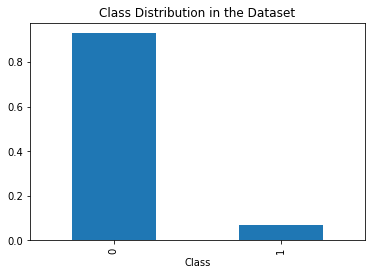

In [6]:
data["label"].value_counts(normalize=True).plot(kind="bar")
plt.title("Class Distribution in the Dataset")
plt.xlabel("Class")

Split randomly the dataset into a training and test sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["label"], test_size=0.33, random_state=42)

## Text processing with nltk and re

Processing relies on four main steps:

*   Lower
*   Remove Punctuations and Stopwords
- Stemming
- Tokenization

In [8]:
nltk.download("stopwords")
stopwords_list = stopwords.words("english")
print(stopwords_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
def process_tweet(tweet, stopwords_list):
    '''
      This function processes a tweet to make it understable for modeling.
      Input:
        tweet: a sentence as strings
        stopword_list : list of stopwords
    '''
  # Lowercase
    tweet = tweet.lower()
  #Remove tags, hastags and internet links
    tweet = re.sub(r"#(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"@(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"https(\w+)", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r"http(\w+)", '', tweet, flags=re.MULTILINE)

  #Remove punctuation
    tweet = re.sub(r"[^\w\s]", '', tweet)
  #Remove empty space
    tweet = re.sub(" +", " ", tweet)

  # Tokenize and remove stopwords
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in stopwords_list]

  # Stemming
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]

    return tweet

In [10]:
tweet_test = X_train[0]
print("Original Tweet: ", tweet_test)
tweet_process = process_tweet(tweet_test, stopwords_list)
print("Processed Tweet: ", tweet_process)

Original Tweet:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Processed Tweet:  ['father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct']


In [11]:
def build_freqs(x, y, stopwords_list):
    '''
      Build a dictionnary of which keys are tuple (word, label) and the corresponding values refer to 
      the count in all documents.
      Input:
        x : list of sentences
        y : list of labels
        stopwords_list : list of stopwords
      '''
    freqs = dict()
    for tweet, label in zip(x, y):
        for word in process_tweet(tweet, stopwords_list):
            pair = (word, label)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

In [12]:
freqs = build_freqs(X_train, y_train, stopwords_list)

In [13]:
V = len(set([pair[0] for pair in freqs.keys()]))
print("The size of vocabulary after processing is: ", V)

The size of vocabulary after processing is:  16686


In [14]:
def build_vector_tweet(dict_freq, train_x, stopwords_list):
    '''
      Build for each tweet a vector understandable for logistic regression model
      Input: 
        dict_freq: dictionnary of frequencies from the functionbuild_freqs
        train_x: list of sentences
        stopwords_list: list of stopwords
      '''
    result = []
    for tweet in train_x:
        tweet = process_tweet(tweet, stopwords_list)
        freq_pos = 0
        frq_neg = 0
        for word in tweet:
            freq_pos =+ dict_freq.get((word,0), 0)
            freq_neg =+ dict_freq.get((word,1), 0)
    
        result.append([1, freq_pos, freq_neg])
    return result

## Training of Logistic Regression

In [15]:
train_x_lr = build_vector_tweet(freqs, X_train, stopwords_list)
train_x_lr = np.array(train_x_lr)
train_y_lr = np.array(y_train)

In [16]:
lr = sk.linear_model.LogisticRegression(penalty='l2', fit_intercept=False)

In [17]:
lr.fit(train_x_lr, train_y_lr)

LogisticRegression(fit_intercept=False)

In [18]:
y_hat_train = lr.predict(train_x_lr)
score = np.mean(y_hat_train==train_y_lr)
print("Accuracy of the model is: ", round(score,2))

Accuracy of the model is:  0.93


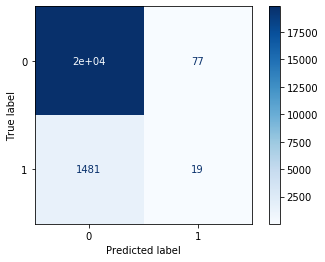

In [19]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, train_x_lr, train_y_lr,
                                 cmap=plt.cm.Blues)

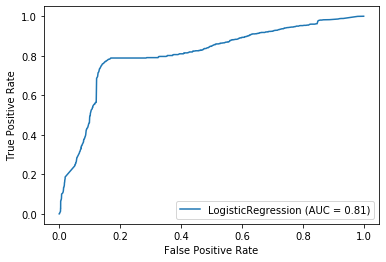

In [20]:
plot_roc_curve(lr, train_x_lr, train_y_lr)

## Find Optimal Point of ROC Curve (Cut-off point)

In [73]:
def compute_tpr_fpr(model, x, y, threshold):
    '''
    Compute TPR and FPR for a given threshold. This threshold is the decision function. 
    If the probability to be an hate speech is superior to this threshold, then the tweet is classified as an hate speech.
    
    Input:
        model : a trained binary classifier
        x : sample of tweets
        y : true labels
        threshold : a float
    '''
    y_hat = lr.predict_proba(x)
    y_hat = y_hat[:,1] > threshold
    y_hat_2 = np.zeros(y_hat.shape)
    for i in range(y_hat.shape[0]):
        if y_hat[i]==True:
            y_hat_2[i] = 1
        else:
            y_hat_2[i] = 0

    mat_ = confusion_matrix(y, y_hat_2)
    
    TPR = mat_[1,1]/(mat_[1,1]+mat_[1,0])
    FPR = mat_[0,1]/(mat_[0,1]+mat_[0,0])
    ACC = np.mean(y_hat_2==y)
    
    return [threshold, TPR, FPR, ACC]
    

In [76]:
roc_curve = []
cut = 0
for i in range(1000):
    cut =+ i*1/1000
    tmp = compute_tpr_fpr(lr, train_x_lr, train_y_lr, cut)
    roc_curve.append(tmp)

In [96]:
freqs.values()

dict_values([11, 109, 8, 15, 2, 57, 88, 12, 25, 12, 48, 721, 770, 36, 101, 106, 237, 60, 1, 48, 209, 365, 515, 429, 273, 1069, 41, 12, 2, 1638, 16, 60, 278, 342, 5, 1, 51, 26, 1, 74, 13, 1022, 1, 45, 205, 69, 15, 56, 545, 54, 63, 41, 597, 14, 165, 174, 209, 31, 3, 2, 28, 20, 290, 139, 269, 168, 182, 40, 95, 28, 135, 39, 14, 1, 4, 34, 2, 756, 487, 775, 217, 337, 512, 61, 866, 142, 13, 517, 249, 1, 3, 87, 33, 262, 117, 1, 382, 99, 59, 14, 131, 204, 11, 63, 1, 33, 5, 43, 3, 30, 6, 27, 17, 13, 1, 5, 2, 4, 12, 13, 8, 34, 9, 29, 315, 5, 6, 4, 44, 178, 64, 105, 3, 542, 614, 4, 17, 5, 18, 486, 321, 34, 159, 78, 35, 75, 27, 37, 88, 6, 46, 1, 79, 142, 39, 202, 344, 13, 131, 121, 21, 134, 15, 123, 52, 126, 1645, 29, 2, 314, 199, 18, 668, 517, 10, 1159, 34, 12, 34, 13, 19, 1, 9, 26, 1, 41, 117, 1, 4, 115, 33, 5, 6, 108, 21, 63, 9, 3, 21, 1, 17, 14, 27, 10, 39, 6, 16, 3, 15, 476, 67, 48, 56, 1, 2, 2, 5, 1, 2, 5, 1, 10, 1, 15, 4, 39, 29, 126, 311, 24, 652, 419, 165, 12, 19, 14, 33, 1, 1, 20, 1, 7, 1

In [103]:
test = pd.DataFrame([[pair[0], pair[1], value] for pair, value in zip(freqs.keys(), freqs.values())])

In [104]:
test.head()

,0,1,2
0,bbc,0,11
1,news,0,109
2,russia,0,8
3,lake,0,15
4,syamozero,0,2
